# MITGCM Regional Spectral Analysis 

**Purpose**: Code for preforming the regional spectral analysis. I will compute the k-omega spectrum for a subset of the model domain in the along- and across-isobath coordinate. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import matplotlib.dates as mdates

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from spectra import spectrum1D_frequency
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function
from spectra import spectrum2D_wavenumber_frequency

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density
option_depth         = 0.5

# Set time and space parameters
L            = 1.5                           # Specifies the distance between points (assumes that ds = dn)
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function    
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/'
PATH_figs =  ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 12

Load intermediate mitgcm data (coordinate transformed)

In [4]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename = PATH + "mitgcm_coord_transform_sn_temp_isobath_2000_res_" + str(L) + "_depth_" + str(option_depth) + "m.npz"
elif option_var == 'sal':
    filename = PATH + "mitgcm_coord_transform_sn_sal_isobath_2000_res_" + str(L) + "_depth_" + str(option_depth) + "m.npz"
elif option_var == 'density':
    filename = PATH + "mitgcm_coord_transform_sn_rho_isobath_2000_res_" + str(L) + "_depth_" + str(option_depth) + "m.npz"

# Load data 
data_struct = np.load(filename, allow_pickle=True)

# Extract data variables
s_coord    = data_struct["s"]
n_coord    = data_struct["n"]
time       = data_struct["time"]
data       = data_struct["data"]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Compute the magnitude of the gradient of temperature

In [ ]:
# Compute gradients along axes: axis 1 = n, axis 2 = s
dT_dn = np.gradient(data, axis=1, edge_order=2) / L
dT_ds = np.gradient(data, axis=2, edge_order=2) / L

# Compute magnitude
gradT = np.sqrt(dT_dn**2 + dT_ds**2)

# Compute direction (in radians)
theta = (90 - np.degrees(np.arctan2(dT_dn, dT_ds))) % 360  

Plot the spatial domain

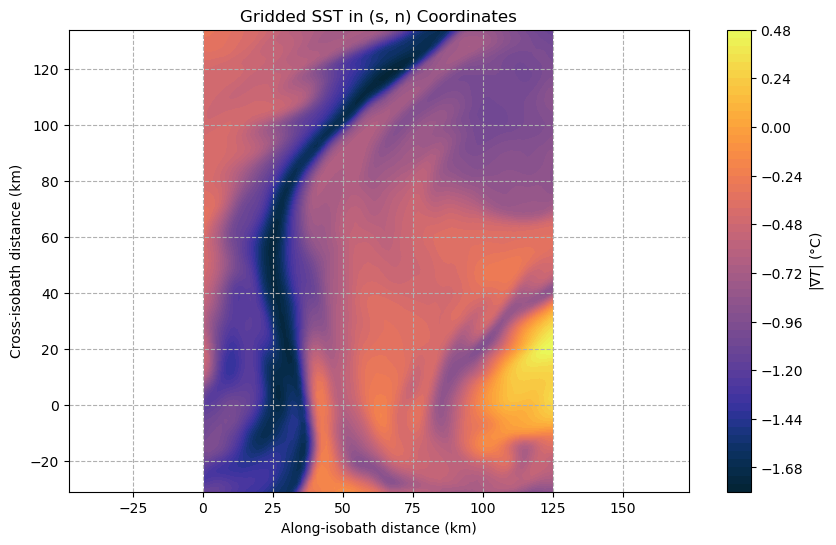

In [62]:
# Set plotting parameters
S, N = np.meshgrid(s_coord, n_coord)

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.contourf(s_coord, n_coord, (data[5000,:,:].T), cmap='cmo.thermal',levels=60)

# Set figure attributes
plt.title('Gridded SST in (s, n) Coordinates')
plt.xlabel('Along-isobath distance (km)')
plt.ylabel('Cross-isobath distance (km)')
plt.colorbar(label=r'$| \nabla T |$ (°C)')
plt.grid(True,linestyle='--')
plt.axis('equal')

# Show the plot
plt.show()

# Save figure
fig.savefig(fname = PATH_figs + 'Temperature_sn_map', bbox_inches = 'tight', dpi=300)

N-coordinate analysis

In [37]:
# Average along the s-coordinate
data_ms = np.mean(gradT,1)

# Compute elapsed seconds from the first time step and convert to units of days
time_seconds = np.array([(t - time_dt[0]).total_seconds() for t in time_dt])
time_days = time_seconds / 86400  # 86400 seconds in a day

# Compute the time and spatce intervals
dt = np.median(np.diff(time_days))
dx = np.median(np.diff(n_coord))

# Set the window parameters
Mt = 5
Mx = 2

# Compute the frequency wavenumber spectrum 
m_spec, kx, f = spectrum2D_wavenumber_frequency(data_ms, time_days, n_coord, dt, dx, Mt, Mx)

Plot spectrum

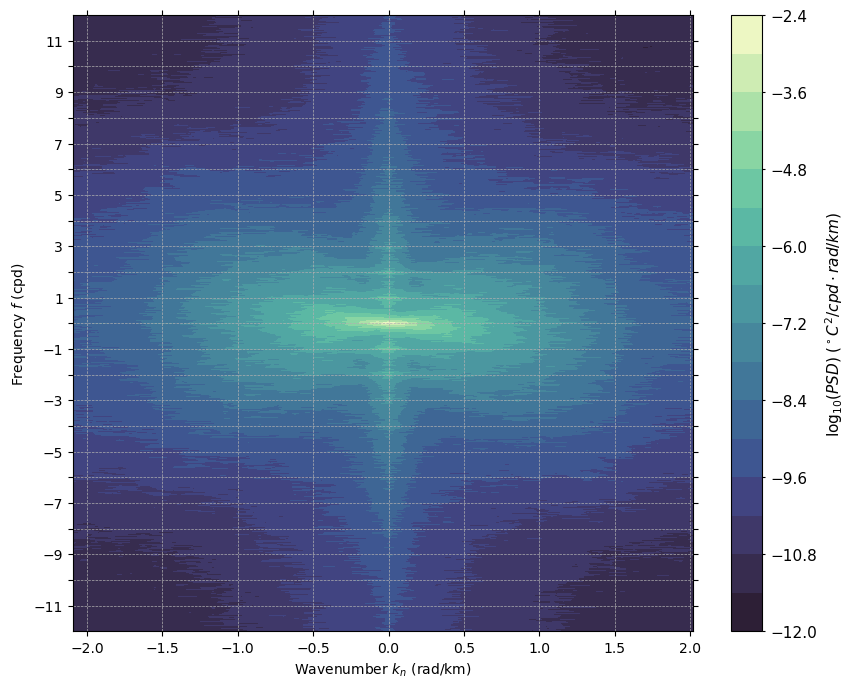

In [38]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(10, 8))

# Plot 
mesh = ax.contourf(kx, f, np.log10(m_spec), levels=15, cmap='cmo.deep_r')

# Set figure attributes
ax.set_xlabel(r'Wavenumber $k_n$ (rad/km)')
ax.set_ylabel(r'Frequency $f$ (cpd)')
ax.set_yticks(np.arange(-11,11+1,1))
ax.grid(True,linestyle='--',linewidth=0.5)
ax.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Get current y-tick positions and labels
yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()

# Show every second y-tick label
ax.set_yticks(yticks)  # keep all ticks
new_labels = [label.get_text() if i % 2 == 0 else '' for i, label in enumerate(yticklabels)]
ax.set_yticklabels(new_labels)

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical')
cb.set_label(r"log$_{10}(PSD) \; (^\circ C^2/cpd\cdot rad/km)$", fontsize=fontsize-1)
#cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

# Show the plot
plt.show()


S-coordinate analysis

In [39]:
# Average along the s-coordinate
data_mn = np.mean(gradT,2)

# Compute elapsed seconds from the first time step and convert to units of days
time_seconds = np.array([(t - time_dt[0]).total_seconds() for t in time_dt])
time_days = time_seconds / 86400  # 86400 seconds in a day

# Compute the time and spatce intervals
dt = np.median(np.diff(time_days))
dx = np.median(np.diff(s_coord))

# Set the window parameters
Mt = 5
Mx = 2

# Compute the frequency wavenumber spectrum 
m_spec, kx, f = spectrum2D_wavenumber_frequency(data_mn, time_days, s_coord, dt, dx, Mt, Mx)

Plot spectrum

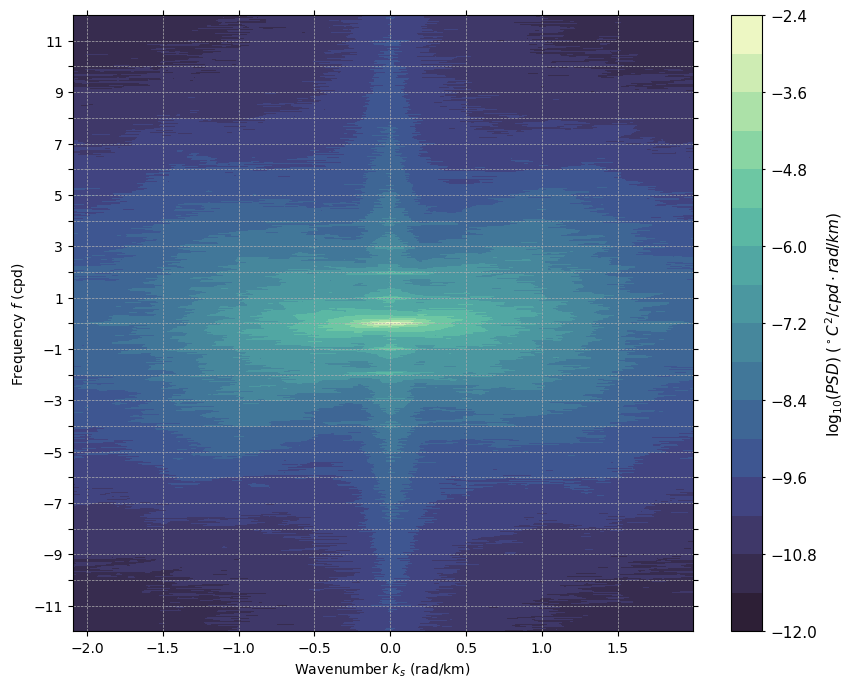

In [40]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(10, 8))

# Plot 
mesh = ax.contourf(kx, f, np.log10(m_spec), levels=15, cmap='cmo.deep_r')

# Set figure attributes
ax.set_xlabel(r'Wavenumber $k_s$ (rad/km)')
ax.set_ylabel(r'Frequency $f$ (cpd)')
ax.set_yticks(np.arange(-11,11+1,1))
ax.grid(True,linestyle='--',linewidth=0.5)
ax.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Get current y-tick positions and labels
yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()

# Show every second y-tick label
ax.set_yticks(yticks)  # keep all ticks
new_labels = [label.get_text() if i % 2 == 0 else '' for i, label in enumerate(yticklabels)]
ax.set_yticklabels(new_labels)

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical')
cb.set_label(r"log$_{10}(PSD) \; (^\circ C^2/cpd\cdot rad/km)$", fontsize=fontsize-1)
#cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

# Show the plot
plt.show()


Compute Power Spectrum in the s-coordinate domain at a single time step

In [50]:
# Set data from a single time step
data_i = data[0, :, :]  # shape (N_n, N_s) = (cross-shore, alongshore)

# Set parameters
N_n, N_s = data_i.shape  # Be careful: shape is (n, s)
dx = L
M = 3
units = 'rad/s'

# Compute frequency axis once for storage
example_psd, f, _, _ = spectrum1D_frequency(data_i[0, :], dx, M, units)

# Initialize spectrogram output array: (n, frequency)
T_spectrogram = np.empty((N_n, len(f)))

# Loop over n-coordinate (cross-shore direction)
for i in range(N_n):
    signal = data_i[i, :]  # 1D signal in the s-direction at cross-shore index i
    psd, f, _, _ = spectrum1D_frequency(signal, dx, M, units)
    T_spectrogram[i, :] = psd


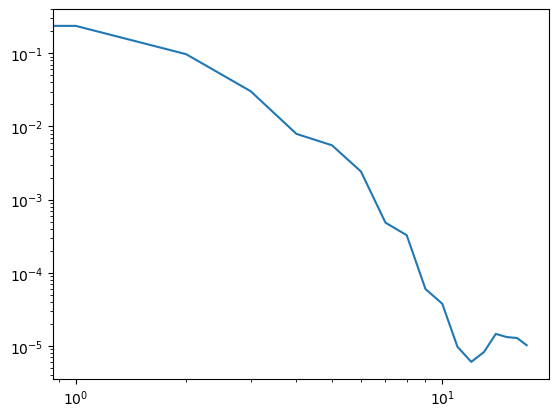

In [51]:
plt.loglog(T_spectrogram[1,:])
plt.show()

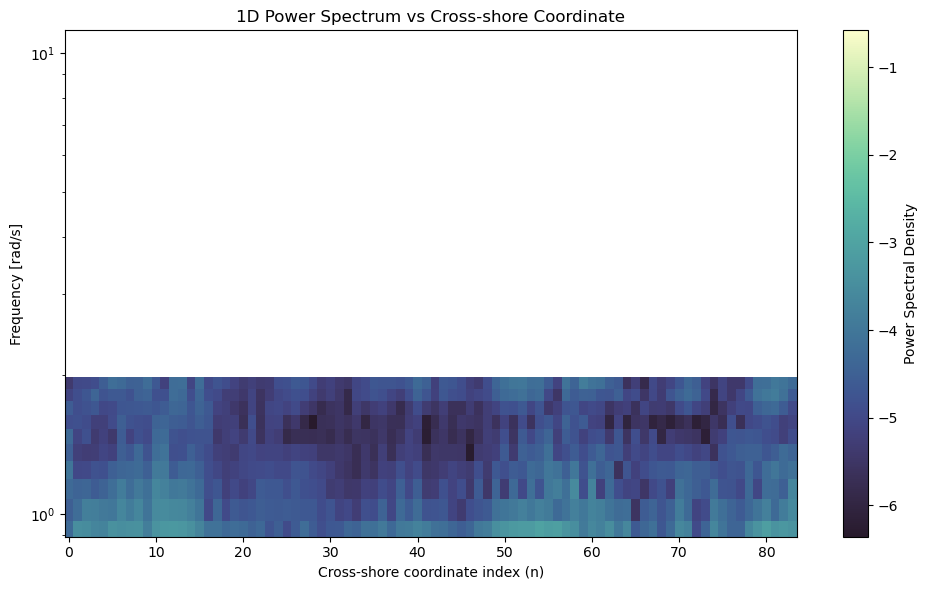

In [52]:
# Create figure axis
plt.figure(figsize=(10, 6))

# Use pcolormesh or imshow to plot power spectrum magnitude (log scale recommended)
# Note: pcolormesh requires 2D grids for axes, so create meshgrid:
N_n, N_f = T_spectrogram.shape
N_n_array = np.arange(N_n)  # replace with actual n_coords if available
N_f_array = f               # frequencies

# Create 2D grids for axes
N_coords_grid, f_grid = np.meshgrid(N_n_array, N_f_array, indexing='ij')

# Plot with pcolormesh, transpose T_spectrogram for correct orientation
pcm = plt.pcolormesh(N_coords_grid, f_grid, np.log10(T_spectrogram), shading='auto', cmap='cmo.deep_r')

plt.colorbar(pcm, label='Power Spectral Density')
plt.xlabel('Cross-shore coordinate index (n)')
plt.ylabel(f'Frequency [{units}]')
plt.title('1D Power Spectrum vs Cross-shore Coordinate')
plt.yscale('log')  # Log scale for frequency axis often better

plt.tight_layout()
plt.show()
